# Detect claims to fact check in political debates

In this project you will implement various classifiers using both neural and feature based technqiues to detect which sentences in political debates should be fact checked.
Dataset from ClaimBuster: https://zenodo.org/record/3609356 
Evaluate your classifiers using the same metrics as http://ranger.uta.edu/~cli/pubs/2017/claimbuster-kdd17-hassan.pdf (Table 2)

Classification report from sklearn provides everything

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import *

# Loading the data

In [2]:
df = pd.read_csv("../data_preprocessing/data_with_stop_words.csv")
df['date'] = pd.to_datetime(df['date'])
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23533 entries, 0 to 23532
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   index       23533 non-null  int64         
 1   date        23533 non-null  datetime64[ns]
 2   Text        23533 non-null  object        
 3   Clean_text  23533 non-null  object        
 4   Verdict     23533 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 919.4+ KB


# Train-test split

In [3]:
mask = df["date"].dt.year < 2012

X_train = df.loc[mask, "Clean_text"].values
y_train = df.loc[mask, "Verdict"].values

X_test = df.loc[~mask, "Clean_text"].values
y_test = df.loc[~mask, "Verdict"].values

# Data Preprocessing

In [4]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

In [5]:
# defining vocabulary
vocabulary = {}
sentences_len = []
for sentence in X_train:
    for term in sentence.split():
        vocabulary.setdefault(term, len(vocabulary))

In [6]:
# Defining vocabulary size
vocabulary_size = list(vocabulary.values())[-1] + 1

print(f"vocabulary is composed of {vocabulary_size} unique words")

vocabulary is composed of 10352 unique words


## One hot encoding representation

Encoding train data

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)

Encodding Test data

In [8]:
X_test_encoded = tokenizer.texts_to_sequences(X_test)

In [22]:
word_index = tokenizer.word_index # same as vocabulary

## Padding sequences

In [16]:
# finding max sentence length
# vec_lengths = []
# for i in X_train_encoded:
#     vec_lengths.append(len(i))


# max_length = np.unique(vec_lengths)[-1]
max_length = 200

In [17]:
X_train_embedded=pad_sequences(X_train_encoded,padding='post',maxlen=max_length)
print(X_train_embedded)

[[  45   16   13 ...    0    0    0]
 [  44   93   22 ...    0    0    0]
 [   1  583 2982 ...    0    0    0]
 ...
 [   3    4   27 ...    0    0    0]
 [ 389 1378    5 ...    0    0    0]
 [   3  389   46 ...    0    0    0]]


### For training

In [18]:
X_train_embedded.shape

(18170, 200)

### For testing

In [19]:
X_test_embedded=pad_sequences(X_test_encoded,padding='post',maxlen=max_length)
print(X_test_embedded.shape)

(5363, 200)


### For the labels

In [20]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(y_train.reshape(-1, 1))
y_encoded = one_hot_encoder.transform(y_train.reshape(-1, 1))

y_encoded.shape

(18170, 3)

In [21]:
y_encoded_test = one_hot_encoder.transform(y_test.reshape(-1,1))
y_encoded_test.shape

(5363, 3)

# Creating the model

In [11]:
# import os
# import zipfile
# with zipfile.ZipFile('../data/glove.zip', 'r') as zip_ref:
#     zip_ref.extractall('../data/glove')

In [15]:
embeddings_index = {}
f = open('../data/glove/glove.6B.200d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [28]:
embedding_matrix = np.zeros((len(vocabulary) + 1, max_length))
for word, i in vocabulary.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [31]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalMaxPool1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.backend import clear_session

In [32]:
clear_session()


### Defining plotting functions

- model history
- confusuion matrix

In [33]:
def plot_model_history(model_history):
    # plot loss during training
    plt.subplot(211)
    plt.title('Loss')
    plt.plot(model_history.history['loss'], label='train')
    plt.plot(model_history.history['val_loss'], label='test')
    plt.legend()
    # plot accuracy during training
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(model_history.history['accuracy'], label='train')
    plt.plot(model_history.history['val_accuracy'], label='test')
    plt.legend()
    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [34]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix'):
    """
    Plot the confusion matrix.
    Normalization is applied by setting `normalize=True`.

    Code soure: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    """
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## LSTM

In [35]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocabulary_size+1, 
                         output_dim=max_length, 
                         input_length=max_length,
                         weights=[embedding_matrix],
                         trainable = False
                         ))
model_lstm.add(LSTM(100))
model_lstm.add(Dense(81, activation = "relu"))
model_lstm.add(Dense(3, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          2070600   
                                                                 
 lstm (LSTM)                 (None, 100)               120400    
                                                                 
 dense (Dense)               (None, 81)                8181      
                                                                 
 dense_1 (Dense)             (None, 3)                 246       
                                                                 
Total params: 2,199,427
Trainable params: 128,827
Non-trainable params: 2,070,600
_________________________________________________________________
None


In [36]:
model_lstm.fit(X_train_embedded,y_encoded, validation_split=0.2, epochs = 10)

Epoch 1/10
455/455 [==============================] - 42s 90ms/step - loss: 0.8358 - accuracy: 0.6734 - val_loss: 0.8918 - val_accuracy: 0.6368
Epoch 2/10
455/455 [==============================] - 44s 96ms/step - loss: 0.8327 - accuracy: 0.6734 - val_loss: 0.8879 - val_accuracy: 0.6368
Epoch 3/10
455/455 [==============================] - 44s 96ms/step - loss: 0.8316 - accuracy: 0.6734 - val_loss: 0.8872 - val_accuracy: 0.6368
Epoch 4/10
455/455 [==============================] - 44s 97ms/step - loss: 0.8322 - accuracy: 0.6734 - val_loss: 0.8897 - val_accuracy: 0.6368
Epoch 5/10
455/455 [==============================] - 43s 94ms/step - loss: 0.8323 - accuracy: 0.6734 - val_loss: 0.8867 - val_accuracy: 0.6368
Epoch 6/10
455/455 [==============================] - 44s 96ms/step - loss: 0.8321 - accuracy: 0.6734 - val_loss: 0.8962 - val_accuracy: 0.6368
Epoch 7/10
455/455 [==============================] - 44s 96ms/step - loss: 0.8315 - accuracy: 0.6734 - val_loss: 0.8867 - val_accuracy:

In [37]:
predictions = model_lstm.predict(X_test_embedded)
preds = one_hot_encoder.inverse_transform(predictions).reshape(-1,)
print(classification_report(y_test, preds, target_names=["NFS", "UFS", "CFS"]))


              precision    recall  f1-score   support

         NFS       0.62      1.00      0.76      3314
         UFS       0.00      0.00      0.00       623
         CFS       0.00      0.00      0.00      1426

    accuracy                           0.62      5363
   macro avg       0.21      0.33      0.25      5363
weighted avg       0.38      0.62      0.47      5363



C:\Users\bruna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bruna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bruna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: Unde

## Bidirectional LSTM 

In [38]:
embedding_dim = 100
model_bi = Sequential()
model_bi.add(Embedding(vocabulary_size+1, 
                         output_dim=max_length, 
                         input_length=max_length,
                         weights=[embedding_matrix],
                         trainable = False
                         ))
model_bi.add(Bidirectional(LSTM(100)))
model_bi.add(Dropout(0.5))
model_bi.add(Dense(97, activation = "relu"))
model_bi.add(Dense(3, activation='softmax'))
model_bi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bi.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 200)          2070600   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              240800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 97)                19497     
                                                                 
 dense_3 (Dense)             (None, 3)                 294       
                                                                 
Total params: 2,331,191
Trainable params: 260,591
Non-trainable params: 2,070,600
______________________________________

In [39]:
model_bi.fit(X_train_embedded,y_encoded, validation_split=0.2, epochs = 3)

Epoch 1/3
455/455 [==============================] - 61s 129ms/step - loss: 0.7591 - accuracy: 0.6890 - val_loss: 0.7543 - val_accuracy: 0.6808
Epoch 2/3
455/455 [==============================] - 60s 132ms/step - loss: 0.6784 - accuracy: 0.7213 - val_loss: 0.7247 - val_accuracy: 0.7039
Epoch 3/3
455/455 [==============================] - 60s 132ms/step - loss: 0.6286 - accuracy: 0.7459 - val_loss: 0.7201 - val_accuracy: 0.7086


In [40]:
predictions = model_bi.predict(X_test_embedded)
preds = one_hot_encoder.inverse_transform(predictions).reshape(-1,)
print(classification_report(y_test, preds, target_names=["NFS", "UFS", "CFS"]))


              precision    recall  f1-score   support

         NFS       0.68      0.97      0.80      3314
         UFS       0.48      0.11      0.18       623
         CFS       0.70      0.26      0.38      1426

    accuracy                           0.68      5363
   macro avg       0.62      0.45      0.45      5363
weighted avg       0.67      0.68      0.62      5363



## Stacked Bi-LSTM

In [41]:
clear_session()

In [42]:
model_Sbi = Sequential()
model_Sbi.add(Embedding(vocabulary_size+1, 
                         output_dim=max_length, 
                         input_length=max_length,
                         weights=[embedding_matrix],
                         trainable = False
                         ))
model_Sbi.add(Dropout(0.2))
model_Sbi.add(Bidirectional(LSTM(100, return_sequences=True)))
model_Sbi.add(Bidirectional(LSTM(100)))
model_Sbi.add(Dropout(0.2))
model_Sbi.add(Dense(97, activation = "relu"))
model_Sbi.add(Dense(3, activation='softmax'))
model_Sbi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_Sbi.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 158, 200)          2070600   
                                                                 
 dropout (Dropout)           (None, 158, 200)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 158, 200)         240800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 97)                1

In [43]:
model_Sbi.fit(X_train_embedded,y_encoded, validation_split=0.2, epochs = 20)

Epoch 1/20
455/455 [==============================] - 120s 255ms/step - loss: 0.6216 - accuracy: 0.7547 - val_loss: 0.6295 - val_accuracy: 0.7427
Epoch 2/20
455/455 [==============================] - 112s 246ms/step - loss: 0.4524 - accuracy: 0.8311 - val_loss: 0.6137 - val_accuracy: 0.7589
Epoch 3/20
455/455 [==============================] - 112s 246ms/step - loss: 0.3464 - accuracy: 0.8732 - val_loss: 0.6961 - val_accuracy: 0.7488
Epoch 4/20
455/455 [==============================] - 112s 246ms/step - loss: 0.2650 - accuracy: 0.9078 - val_loss: 0.7628 - val_accuracy: 0.7433
Epoch 5/20
455/455 [==============================] - 111s 244ms/step - loss: 0.2018 - accuracy: 0.9331 - val_loss: 0.8746 - val_accuracy: 0.7289
Epoch 6/20
455/455 [==============================] - 111s 244ms/step - loss: 0.1603 - accuracy: 0.9467 - val_loss: 0.8963 - val_accuracy: 0.7342
Epoch 7/20
455/455 [==============================] - 111s 245ms/step - loss: 0.1274 - accuracy: 0.9587 - val_loss: 1.0283 -

In [44]:
predictions = model_Sbi.predict(X_test_embedded)
preds = one_hot_encoder.inverse_transform(predictions).reshape(-1,)
print(classification_report(y_test, preds, target_names=["NFS", "UFS", "CFS"]))


              precision    recall  f1-score   support

         NFS       0.78      0.85      0.81      3314
         UFS       0.38      0.32      0.35       623
         CFS       0.59      0.50      0.54      1426

    accuracy                           0.70      5363
   macro avg       0.58      0.56      0.57      5363
weighted avg       0.68      0.70      0.69      5363



## Convolutional Neural Network

In [85]:
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D
clear_session()


In [48]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(vocabulary_size+1, 
                         output_dim=max_length, 
                         input_length=max_length,
                         weights=[embedding_matrix],
                         trainable = False
                         ))
model.add(Conv1D(128, 10, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 158, 100)          1035300   
                                                                 
 conv1d (Conv1D)             (None, 149, 128)          128128    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1,167,655
Trainable params: 1,167,655
Non-trainable params: 0
____________________________________________

In [49]:
model.fit(X_train_embedded,y_encoded, validation_split=0.2, epochs = 5)

Epoch 1/5
455/455 [==============================] - 11s 23ms/step - loss: 0.6378 - accuracy: 0.7444 - val_loss: 0.6041 - val_accuracy: 0.7485
Epoch 2/5
455/455 [==============================] - 10s 23ms/step - loss: 0.4010 - accuracy: 0.8506 - val_loss: 0.6129 - val_accuracy: 0.7523
Epoch 3/5
455/455 [==============================] - 10s 23ms/step - loss: 0.1930 - accuracy: 0.9355 - val_loss: 0.7587 - val_accuracy: 0.7529
Epoch 4/5
455/455 [==============================] - 11s 23ms/step - loss: 0.0694 - accuracy: 0.9800 - val_loss: 0.9866 - val_accuracy: 0.7466
Epoch 5/5
455/455 [==============================] - 11s 23ms/step - loss: 0.0222 - accuracy: 0.9942 - val_loss: 1.1839 - val_accuracy: 0.7460


In [50]:
predictions = model.predict(X_test_embedded)
preds = one_hot_encoder.inverse_transform(predictions).reshape(-1,)
print(classification_report(y_test, preds, target_names=["NFS", "UFS", "CFS"]))

              precision    recall  f1-score   support

         NFS       0.77      0.90      0.83      3314
         UFS       0.43      0.36      0.39       623
         CFS       0.68      0.47      0.56      1426

    accuracy                           0.72      5363
   macro avg       0.63      0.58      0.59      5363
weighted avg       0.71      0.72      0.71      5363



Confusion matrix, without normalization


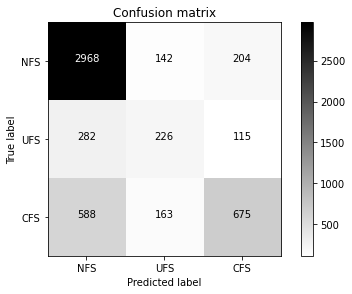

In [55]:
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=["NFS", "UFS", "CFS"])


## Convolutional Neural network + LSTM

In [63]:
model_conv = Sequential()
model_conv.add(Embedding(vocabulary_size+1, 
                         output_dim=max_length, 
                         input_length=max_length,
                         weights=[embedding_matrix],
                         trainable = False
                         ))
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(128, 10, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=10))
model_conv.add(LSTM(100))
model_conv.add(Dense(32, activation = "relu"))
model_conv.add(Dense(3, activation='softmax'))
model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [64]:
model_conv.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 158, 100)          1035300   
                                                                 
 dropout_3 (Dropout)         (None, 158, 100)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 149, 128)          128128    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 14, 128)          0         
 1D)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 100)               91600     
                                                                 
 dense_6 (Dense)             (None, 32)                3232      
                                                      

In [65]:
model_conv.fit(X_train_embedded,y_encoded, validation_split=0.2, epochs = 10)

Epoch 1/10
455/455 [==============================] - 17s 34ms/step - loss: 0.6922 - accuracy: 0.7308 - val_loss: 0.6663 - val_accuracy: 0.7408
Epoch 2/10
455/455 [==============================] - 15s 33ms/step - loss: 0.5114 - accuracy: 0.8056 - val_loss: 0.6466 - val_accuracy: 0.7364
Epoch 3/10
455/455 [==============================] - 15s 32ms/step - loss: 0.3874 - accuracy: 0.8484 - val_loss: 0.7117 - val_accuracy: 0.7380
Epoch 4/10
455/455 [==============================] - 14s 32ms/step - loss: 0.2597 - accuracy: 0.9058 - val_loss: 0.8569 - val_accuracy: 0.7091
Epoch 5/10
455/455 [==============================] - 14s 32ms/step - loss: 0.1623 - accuracy: 0.9454 - val_loss: 1.0488 - val_accuracy: 0.7339
Epoch 6/10
455/455 [==============================] - 14s 32ms/step - loss: 0.1017 - accuracy: 0.9673 - val_loss: 1.0691 - val_accuracy: 0.7204
Epoch 7/10
455/455 [==============================] - 15s 32ms/step - loss: 0.0685 - accuracy: 0.9783 - val_loss: 1.1695 - val_accuracy:

In [66]:
predictions = model_conv.predict(X_test_embedded)
preds = one_hot_encoder.inverse_transform(predictions).reshape(-1,)
print(classification_report(y_test, preds, target_names=["NFS", "UFS", "CFS"]))


              precision    recall  f1-score   support

         NFS       0.77      0.88      0.82      3314
         UFS       0.37      0.37      0.37       623
         CFS       0.65      0.44      0.52      1426

    accuracy                           0.70      5363
   macro avg       0.60      0.56      0.57      5363
weighted avg       0.69      0.70      0.69      5363



Confusion matrix, without normalization


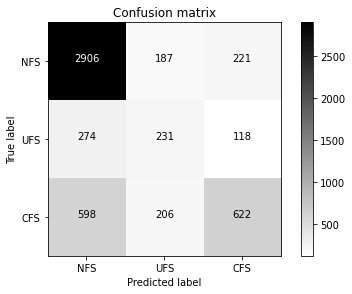

In [67]:
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=["NFS", "UFS", "CFS"])